# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

## Подготовка данных

Добрый день!
Представляю Вашему вниманию проект, в котором попытаюсь спрогнозировать, уйдёт ли клиент из "Бета-Банка" в ближайшее время или нет. Исходными данными для Меня предоставлены исторические данные о поведении клиентов и расторжении договоров с "Бета-Банком".
Я постараюсь построить модель с предельно большим значением F1-меры. Дополнительно измерю AUC-ROC и сравнивню её значение с F1-мерой.

Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve

Игнорируем предупреждения:

In [2]:
import warnings
warnings.filterwarnings('ignore')

Откроем файл:

In [3]:
data = pd.read_csv('/datasets/Churn.csv')

Выведем первые строки датафрейма:

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Выведем основную информацию датафрейма:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Приведёт наименования столбцов к нижнему регистру:

In [6]:
data.columns = data.columns.str.lower()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Заполним пропущенные значения в столбце 'tenure' 

In [8]:
data['tenure'] = data['tenure'].fillna(0)

Удалим ненужные признаки:

In [9]:
data = data.drop(['rownumber', 'customerid', 'surname'],  axis = 1)

Преобразуем категориальный признак техникой OHE:

In [10]:
data_ohe = pd.get_dummies(data, drop_first=True)

Создадим переменные для признаков и целевого признака:

In [11]:
features = data_ohe.drop('exited', axis = 1)
target = data_ohe['exited']

Выделим из исходных данных тренировочную выборку:

In [12]:
data_train, data_temp = train_test_split(data_ohe, train_size=0.6, random_state=12345)

Оставшиеся данные поделим пополам на валидационную и тестовые выборки:

In [13]:
data_valid, data_test = train_test_split(data_temp, test_size=0.5, random_state=12345)

Выведем размер таблицы, получившихся выборок:

In [14]:
data_ohe.shape

(10000, 12)

In [15]:
data_train.shape

(6000, 12)

In [16]:
data_valid.shape

(2000, 12)

In [17]:
data_test.shape

(2000, 12)

Создадим переменные для признаков и целевого признака для тренировочной, валидационной и тестовой выборки:

In [18]:
features_train = data_train.drop(['exited'], axis=1)
target_train = data_train['exited']
features_valid = data_valid.drop(['exited'], axis=1)
target_valid = data_valid['exited']
features_test = data_test.drop(['exited'], axis=1)
target_test = data_test['exited']

Приведём численные признаки к одному масштабу:

In [19]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

Исследуем качество модели на тренировочной выборке с помощью модели "Случайный лес":

In [20]:
for est in range(1, 11):
    model_RFC = RandomForestClassifier(random_state=12345, n_estimators= est)
    model_RFC.fit(features_train, target_train)
    predictions_valid_RFC = model_RFC.predict(features_valid)
    print("max_est =", est, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid_RFC))

max_est = 1 : 0.785
max_est = 2 : 0.827
max_est = 3 : 0.827
max_est = 4 : 0.838
max_est = 5 : 0.838
max_est = 6 : 0.8455
max_est = 7 : 0.8515
max_est = 8 : 0.852
max_est = 9 : 0.854
max_est = 10 : 0.8535


In [21]:
model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100, max_depth = 13)
model_RFC.fit(features_train, target_train)
result_RFC = model_RFC.score(features_valid, target_valid)
predicted_valid = model_RFC.predict(features_valid)
f1_score(target_valid, predicted_valid)

0.5849923430321593

In [22]:
print('AUC-ROC:', roc_auc_score(target_valid, predicted_valid))

AUC-ROC: 0.714562451986765


Метрика F1 далека от идеала, в дальнейшем постараемся улучшить наши показатели...

## Борьба с дисбалансом

На первом этапе поборемся с дисбалансом классов с помощью техники увеличения выборки:

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = np.concatenate([features_zeros] + [features_ones] * repeat)
    target_upsampled = np.concatenate([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

выполнил определение гиперпараметров

In [25]:
best_results_up = 0
est_best_up = 0
depth_best_up = 0
for est in range (20,101,10):
    for depth in range (5,20,1):
        model_up = RandomForestClassifier(random_state=12345, n_estimators = est, max_depth = depth)
        model_up.fit(features_upsampled, target_upsampled)
        predict_up = model_up.predict(features_valid)
        results_up = f1_score(target_valid, predict_up)
        if results_up > best_results_up:
            best_results_up = results_up
            est_best_up = est
            depth_best_up = depth
print(best_results_up, est_best_up, depth_best_up)

0.6289156626506025 100 13


In [26]:
model_up = RandomForestClassifier(random_state=12345, n_estimators = 100, max_depth = 13)
model_up.fit(features_upsampled, target_upsampled)
predicted_valid_up = model_up.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_up))

F1: 0.6289156626506025


выполнил балансировку весов классов

In [27]:
probabilities_valid_up = model_up.predict_proba(features_valid)
probabilities_one_valid_up = probabilities_valid_up[:, 1]
print(probabilities_one_valid_up[:50])

[0.05271164 0.59450491 0.31638994 0.19708648 0.03840956 0.02881885
 0.10483176 0.11394746 0.10203198 0.2926908  0.52121902 0.02092148
 0.01914251 0.22568521 0.82846472 0.03361181 0.02680562 0.8811792
 0.22604352 0.3194939  0.04440028 0.44904757 0.81337468 0.33007393
 0.03487244 0.02888886 0.39198129 0.05614516 0.01482534 0.17248377
 0.05545116 0.33758084 0.04422327 0.24616829 0.25453566 0.15118971
 0.09199423 0.27147198 0.01796456 0.79339234 0.59308253 0.68433975
 0.02376392 0.01352958 0.63365779 0.98953613 0.59967269 0.01087943
 0.16197443 0.00317686]


In [28]:
for threshold in np.arange(0, 1.0, 0.02):
    predicted_valid_up = probabilities_one_valid_up > threshold
    precision_up = precision_score(target_valid, predicted_valid_up)
    recall_up = recall_score(target_valid, predicted_valid_up)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision_up, recall_up))

Порог = 0.00 | Точность = 0.209, Полнота = 1.000
Порог = 0.02 | Точность = 0.222, Полнота = 0.995
Порог = 0.04 | Точность = 0.236, Полнота = 0.988
Порог = 0.06 | Точность = 0.248, Полнота = 0.971
Порог = 0.08 | Точность = 0.261, Полнота = 0.964
Порог = 0.10 | Точность = 0.275, Полнота = 0.952
Порог = 0.12 | Точность = 0.291, Полнота = 0.938
Порог = 0.14 | Точность = 0.303, Полнота = 0.923
Порог = 0.16 | Точность = 0.318, Полнота = 0.911
Порог = 0.18 | Точность = 0.334, Полнота = 0.890
Порог = 0.20 | Точность = 0.354, Полнота = 0.880
Порог = 0.22 | Точность = 0.369, Полнота = 0.861
Порог = 0.24 | Точность = 0.384, Полнота = 0.847
Порог = 0.26 | Точность = 0.399, Полнота = 0.821
Порог = 0.28 | Точность = 0.418, Полнота = 0.801
Порог = 0.30 | Точность = 0.439, Полнота = 0.787
Порог = 0.32 | Точность = 0.452, Полнота = 0.763
Порог = 0.34 | Точность = 0.468, Полнота = 0.746
Порог = 0.36 | Точность = 0.492, Полнота = 0.730
Порог = 0.38 | Точность = 0.515, Полнота = 0.722
Порог = 0.40 | Точно

На втором этапе поборемся с дисбалансом классов с помощью техники уменьшения выборки:

In [29]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

In [30]:
best_results_down = 0
est_best_down = 0
depth_best_down = 0
for est in range (20,101,10):
    for depth in range (5,20,1):
        model_down = RandomForestClassifier(random_state=12345, n_estimators = est, max_depth = depth)
        model_down.fit(features_downsampled, target_downsampled)
        predict_down = model_down.predict(features_valid)
        results_down = f1_score(target_valid, predict_down)
        if results_down > best_results_down:
            best_results_down = results_down
            est_best_down = est
            depth_best_down = depth
print(best_results_down, est_best_down, depth_best_down)

0.6261980830670926 70 5


In [31]:
model_down = RandomForestClassifier(random_state=12345, n_estimators = 70, max_depth = 5)
model_down.fit(features_downsampled, target_downsampled)
predicted_valid_down = model_down.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid_down))

F1: 0.6261980830670926


In [32]:
probabilities_valid_down = model_down.predict_proba(features_valid)
probabilities_one_valid_down = probabilities_valid_down[:, 1]
print(probabilities_one_valid_down[:50])

[0.2077646  0.5717485  0.46132219 0.28234758 0.35070203 0.32331307
 0.20270575 0.21937943 0.38680488 0.48517426 0.62786866 0.18980069
 0.12456775 0.35700439 0.85907912 0.18402316 0.15099239 0.7470489
 0.39413467 0.4133014  0.21715471 0.70778428 0.71073356 0.3856384
 0.2246533  0.18217291 0.49983571 0.35484414 0.13100029 0.4226598
 0.32125639 0.34186562 0.25569296 0.37448584 0.45777359 0.2118456
 0.29409459 0.30194067 0.15103097 0.76171322 0.47413887 0.3755101
 0.19155642 0.14476425 0.59634474 0.8358817  0.51806498 0.12547539
 0.28507263 0.12529998]


In [33]:
for threshold in np.arange(0, 1.0, 0.02):
    predicted_valid_down = probabilities_one_valid_down > threshold
    precision_down = precision_score(target_valid, predicted_valid_down)
    recall_down = recall_score(target_valid, predicted_valid_down)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision_down, recall_down))

Порог = 0.00 | Точность = 0.209, Полнота = 1.000
Порог = 0.02 | Точность = 0.209, Полнота = 1.000
Порог = 0.04 | Точность = 0.209, Полнота = 1.000
Порог = 0.06 | Точность = 0.209, Полнота = 1.000
Порог = 0.08 | Точность = 0.209, Полнота = 1.000
Порог = 0.10 | Точность = 0.209, Полнота = 1.000
Порог = 0.12 | Точность = 0.210, Полнота = 1.000
Порог = 0.14 | Точность = 0.216, Полнота = 0.998
Порог = 0.16 | Точность = 0.226, Полнота = 0.990
Порог = 0.18 | Точность = 0.235, Полнота = 0.986
Порог = 0.20 | Точность = 0.254, Полнота = 0.981
Порог = 0.22 | Точность = 0.263, Полнота = 0.955
Порог = 0.24 | Точность = 0.271, Полнота = 0.945
Порог = 0.26 | Точность = 0.281, Полнота = 0.928
Порог = 0.28 | Точность = 0.291, Полнота = 0.919
Порог = 0.30 | Точность = 0.302, Полнота = 0.911
Порог = 0.32 | Точность = 0.323, Полнота = 0.897
Порог = 0.34 | Точность = 0.343, Полнота = 0.880
Порог = 0.36 | Точность = 0.369, Полнота = 0.866
Порог = 0.38 | Точность = 0.394, Полнота = 0.840
Порог = 0.40 | Точно

In [34]:
for threshold in np.arange(0, 1.0, 0.02):
    predicted_valid_down = probabilities_one_valid_down > threshold
    precision_down = precision_score(target_valid, predicted_valid_down)
    recall_down = recall_score(target_valid, predicted_valid_down)
    f1 = f1_score(target_valid, predicted_valid_down)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision_down, recall_down, f1))

Порог = 0.00 | Точность = 0.209, Полнота = 1.000, F1 = 0.346
Порог = 0.02 | Точность = 0.209, Полнота = 1.000, F1 = 0.346
Порог = 0.04 | Точность = 0.209, Полнота = 1.000, F1 = 0.346
Порог = 0.06 | Точность = 0.209, Полнота = 1.000, F1 = 0.346
Порог = 0.08 | Точность = 0.209, Полнота = 1.000, F1 = 0.346
Порог = 0.10 | Точность = 0.209, Полнота = 1.000, F1 = 0.346
Порог = 0.12 | Точность = 0.210, Полнота = 1.000, F1 = 0.347
Порог = 0.14 | Точность = 0.216, Полнота = 0.998, F1 = 0.355
Порог = 0.16 | Точность = 0.226, Полнота = 0.990, F1 = 0.368
Порог = 0.18 | Точность = 0.235, Полнота = 0.986, F1 = 0.380
Порог = 0.20 | Точность = 0.254, Полнота = 0.981, F1 = 0.403
Порог = 0.22 | Точность = 0.263, Полнота = 0.955, F1 = 0.412
Порог = 0.24 | Точность = 0.271, Полнота = 0.945, F1 = 0.421
Порог = 0.26 | Точность = 0.281, Полнота = 0.928, F1 = 0.431
Порог = 0.28 | Точность = 0.291, Полнота = 0.919, F1 = 0.442
Порог = 0.30 | Точность = 0.302, Полнота = 0.911, F1 = 0.454
Порог = 0.32 | Точность 

Пименим балансировку весов классов (class_weight):

In [35]:
model_balanced = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_balanced.fit(features_train, target_train)
predicted_valid = model_balanced.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5609756097560976


In [40]:
target_downsampled.value_counts(normalize=True)

0    0.546454
1    0.453546
Name: exited, dtype: float64

Качество модели выше при увеличении выборки, применим полученные данные для тестирования модели...

## Тестирование модели

протестируем модель после учета дисбаланса кассов:

In [36]:
model_test = RandomForestClassifier(random_state=12345, n_estimators = 100, max_depth = 13)
#model_test.fit(features_upsampled, target_upsampled)
#predictions_test = model_test.predict(features_upsampled)
#print('Тестовая модель')
#print('F1:', f1_score(target_upsampled, predictions_test))
model_test.fit(features_upsampled, target_upsampled)
predicted_valid_test = model_test.predict(features_valid)
print('Тестовая модель')
print("F1:", f1_score(target_valid, predicted_valid_test))

Тестовая модель
F1: 0.6289156626506025


In [41]:
f1_score(model_test.predict(features_test), target_test)

0.6064981949458483

In [37]:
print('AUC-ROC:', roc_auc_score(target_valid, predicted_valid))

AUC-ROC: 0.7030286899872368


Мы получили очень хорошие показатели метрики F1

Изобразим PR-кривую на графике и посмотрим как выглядят значения метрик...

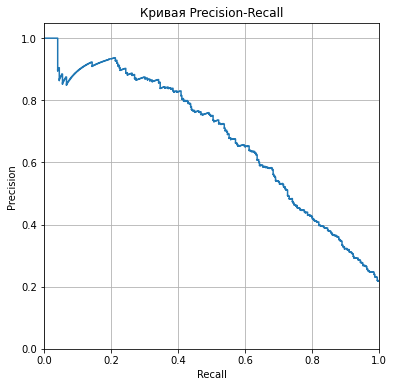

In [38]:
probabilities_valid = model_test.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.grid()
plt.show() 

Чем выше кривая, тем лучше модель...

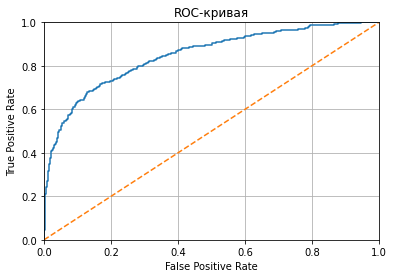

In [39]:
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1]) # < напишите код здесь >
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid()
plt.show()

Короткий путь не самый лучший)))...

В этом проекте я  спрогнозировал, уйдёт ли клиент из "Бета-Банка" в ближайшее время или нет...
Мною были подготовлены даннные и исследована задача классификации, исследован балас классов техниками: увеличения и уменьшения выборки. 
Проведено тестирование модели. Полученное значение F1-меры выше 0,59 говорит о том, что прогноз класса 1 удался, т.е. положительный класс хорошо прогнозируется...
Следовательно можно предположить, что в ближайшее время действительно произойдёт отток клиентов и необходимо принять какие либо меры по удержанию клиентов:    